# 内容提要
- Logistic回归: 原理与`sklearn`调用
- 模型评估的常用指标
- 交叉验证

# Logistic回归: 原理与`sklearn`调用

$\quad$作为监督学习的另一类别, **分类**(classification)问题所需处理的标签$t^{(n)}$是取自类别标签集$\mathcal{C}$的离散、有限值. 此时, 为了实现连续化(以便对损失函数求梯度), 常用做法是将模型输出以激活函数$y^{(n)} = \sigma(\cdot)$做有界化处理, 再根据$y^{(n)}$的取值作出分类决策. 许多模型中, $y^{(n)}$都处于$[0, 1]$范围内, 并被解读为概率.

$\quad$以二元分类$\mathcal{C} = {0, 1}$为例, 若将$y^{(n)}$解读为样本分属类别$t = 1$的概率, 则可由Bernoulli分布写出其似然函数, 并按负对数似然(NLL)定义损失函数:

$$\begin{aligned}
\mathcal{L}(\mathbf{w}; \mathcal{D}) &:= -\log{\left(\prod_{n=1}^N{(y^{(n)})^{t^{(n)}}}(1 - y^{(n)})^{1 - t^{(n)}}\right)}\\
&= -\sum_{n=1}^N{\left(t^{(n)}\log{y^{(n)}} + (1 - t^{(n)})\log{(1 - y^{(n)})}\right)}.
\end{aligned}$$

$\quad$记类别数目为$c = |\mathcal{C}|$. 以**独热向量**(one-hot vector)标记样本$n$的真实标签为$\mathbf{t}^{(n)} \in \{0, 1\}^c$, 将各类别概率整理为(分量和为1的)向量$\mathbf{y}^{(n)} \in [0, 1]^c$, 则优化目标事实上等价于**交叉熵**(cross entropy)和**KL散度**(Kullback-Leibler divergence):

$$\begin{aligned}
\mathbf{w}^* &= \arg{\min_{\mathbf{w} \in \mathcal{W}}{\mathcal{L}(\mathbf{w}; \mathcal{D})}}\\
&= \arg{\min_{\mathbf{w} \in \mathcal{W}}{\left\{-\sum_{n=1}^N{\mathbf{t}^{(n)} \cdot \log{\mathbf{y}(\mathbf{x}^{(n)}; \mathbf{w})}}\right\}}} = \arg{\min_{\mathbf{w} \in \mathcal{W}}{\mathrm{CrossEntropy}(\mathbf{T}, \mathbf{Y})}}\\
&= \arg{\min_{\mathbf{w} \in \mathcal{W}}{\left\{\sum_{n=1}^N{\mathbf{t}^{(n)} \cdot \log{\mathbf{t}^{(n)}}} - \sum_{n=1}^N{\mathbf{t}^{(n)} \cdot \log{\mathbf{y}(\mathbf{x}^{(n)}; \mathbf{w})}}\right\}}} = \arg{\min_{\mathbf{w} \in \mathcal{W}}{D_\mathrm{KL}(\mathbf{T} \| \mathbf{Y})}}.
\end{aligned}$$
这让我们对Bernoulli NLL有了新的理解: **使预测的类别概率分布尽可能接近真实的(独热)分布**.

## Logistic回归基本原理

$\quad$**Logistic回归**(Logistic regression)是相当基础但应用广泛的分类模型, 它是**SoftMax回归**(SoftMax regression)在二元分类问题($c = 2$时的特例). 在取交叉熵(也就是Bernoulli NLL)为损失函数的基础上, 我们将假设函数定为(经由Sigmoid函数激活的)线性函数:

$$
y(\mathbf{x}; \mathbf{w}) = \sigma(\mathbf{w}^\mathrm{T}\mathbf{x}),\,\,\sigma(a) := \frac{1}{1 + \mathrm{e}^{-a}}.
$$

所以, Logistic回归本质也是一种**线性模型**(linear model), 它假定数据标签的**对数似然比**(log odd ratio)关于特征$\mathbf{x}$是线性的, 即:

$$
\log{\frac{y}{1 - y}} = \mathbf{w}^\mathrm{T}\mathbf{x}.
$$

这里的隐变量$a = \mathbf{w}^\mathrm{T}\mathbf{x}$被Sigmoid函数处理后, 输出$y$将恒落在$(0, 1)$的界限内, 进而被解释为标签取1的概率. 我们不妨再作出Sigmoid函数的曲线, 加强直观印象.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

def sigmoid(a: np.array) -> np.array:
    return 1 / (1 + np.exp(-a))

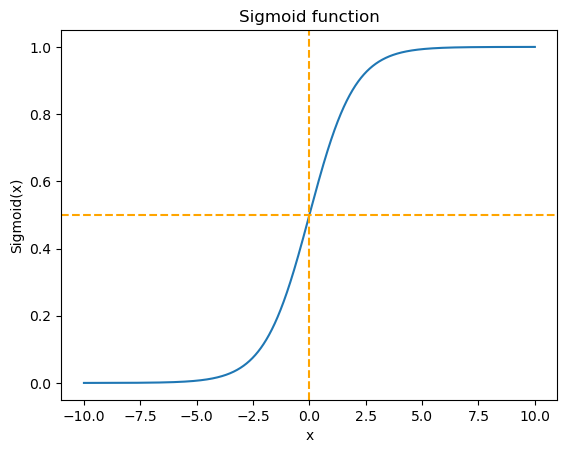

In [2]:
a = np.linspace(-10, 10, num=10000)
plt.title("Sigmoid function")
plt.xlabel("x")
plt.ylabel("Sigmoid(x)")
plt.plot(a, sigmoid(a))
plt.axhline(0.5, linestyle="--", color="orange")
plt.axvline(0, linestyle="--", color="orange")
plt.show()

## 演示数据集: 乳腺癌肿瘤预测

$\quad$我们以二元分类数据集[`breast_cancer`](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset)为例进行演示. 这是`sklearn`中的[内置数据集](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer), 收集了细针抽吸活检(fine-needle aspiration, FNA)预测目标是肿瘤的恶性(`malignant`, 标记为1)或良性(`benign`, 标记为0). 我们下面进行数据集的读取与初步探索: 特征维度、样本数目与类别统计. 这里介绍一些有用的新方法:
- 特征的基本数值分布可用[`df.describe()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html#pandas-dataframe-describe)方法查看;
- 可用[`df.corr()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html#pandas-dataframe-corr)方法计算特征维度之间的互相关效应(Pearson相关系数), 并以[`seaborn.heatmap()`](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn-heatmap)方法作出直观的相关系数图;
- 类别标签可由[`df.plot()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html#pandas-dataframe-plot)方法作出直观的图示(例如: 作出分布饼图, 并设置将样本占比输出在饼图上).

In [3]:
from sklearn.datasets import load_breast_cancer
X, y_true = load_breast_cancer(as_frame=True, return_X_y=True)

In [4]:
# `df.describe()` to inspect feature summary
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


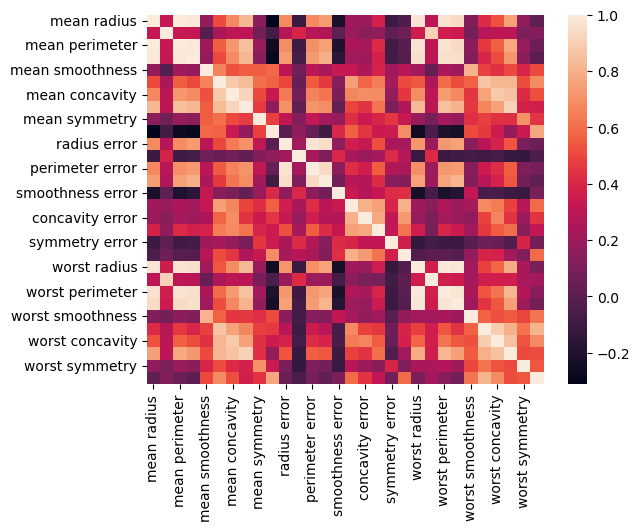

In [5]:
# view and plot correlation
from matplotlib import pyplot as plt
import seaborn as sns

sns.heatmap(X.corr())
plt.show()

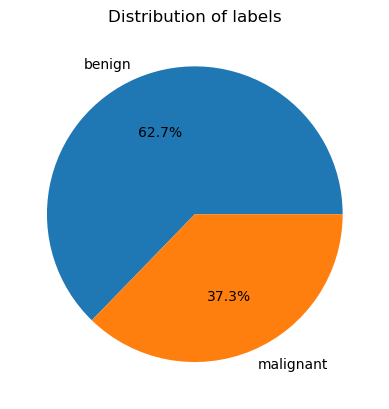

In [6]:
# pie plot of label distribution
import pandas as pd
y_counts = pd.Series(
    np.array(y_true.value_counts()), index=["benign", "malignant"]
)
y_counts.plot(
    kind="pie",
    title="Distribution of labels",
    autopct='%1.1f%%',
)
plt.show()

## 模型的训练与求解

$\quad$以二分类问题为例, 对损失函数

$$
\mathcal{L}(\mathbf{w}; \mathcal{D}) = - \sum_{n=1}^N{\left(t^{(n)}\log{y^{(n)}} + (1 - t^{(n)})\log{(1 - y^{(n)})}\right)}
$$

求取(关于参数的)梯度, 得到:

$$
\nabla_\mathbf{w}\mathcal{L} = \sum_{n=1}^N{y^{(n)}(1 - y^{(n)})\mathbf{x}^{(n)}},
$$

随后, 即可利用各种基于梯度的数值优化算法实现模型训练.

$\quad$在`sklearn`中, Logistic模型以[`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn-linear-model-logisticregression)实现调用.
- 与线性回归模型类似, 模型训练与预测的工作流仍然是: (1) 创建模型对象`clf`; (2) 以训练数据和`clf.fit()`方法实现模型训练; (3) 将特征输入`clf.predict()`(标签预测值)或`clf.predict_proba()`(概率预测值)方法实现新数据的预测.
- 与线性回归模型不同的点在于, Logistic回归在`sklearn`中的实现是默认加了$\alpha = 1.0$的$L_2$-范数正则化. 而且正则化强度以$C$表示, 实际等价为$\alpha$的**倒数**. 所以, `sklearn`中待优化的Logistic回归的目标函数默认为

$$
\tilde{\mathcal{L}} = - C \sum_{n=1}^N{\left(t^{(n)}\log{y^{(n)}} + (1 - t^{(n)})\log{(1 - y^{(n)})}\right)} + \frac{1}{2}\|\mathbf{w}\|_2^2,
$$

且默认$C=1.0$. 具体的$C$值可通过参数`C`实现调节. 若不希望加正则化, 可设置参数`penalty="none"`.

$\quad$首先, 我们将数据集按照**训练:测试=0.75:0.25**的比例进行数据拆分, 并各自进行均值归一化(注意: 利用**训练集**上的均值、方差完成所有归一化). 这步归一化是相当必要的, 因为原始特征各个分量的标度值差别很大.

In [7]:
# split the dataset with ratio train:test=3:1
test_ratio = 0.25
from sklearn.model_selection import train_test_split
X_train, X_test, y_true_train, y_true_test = train_test_split(X, y_true, test_size=test_ratio)
X_train.shape, X_test.shape

((426, 30), (143, 30))

In [8]:
# rescale the data using `StandardScaler`
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled.mean(), X_train_scaled.std()

(-4.996872329924805e-17, 1.0)

$\quad$随后, 我们进行模型训练, 并给出训练集、测试集上的真实标签与预测标签. 简化起见, 我们先按默认的超参数设置$C=1.0$进行处理.

In [9]:
# train and test the model
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train_scaled, y_true_train)
y_pred_train = clf.predict(X_train_scaled)
y_pred_test = clf.predict(X_test_scaled)

In [10]:
# reset the indices
y_true_train = y_true_train.reset_index(drop=True)
y_true_train[:5], y_pred_train[:5]

(0    1
 1    0
 2    1
 3    1
 4    1
 Name: target, dtype: int32,
 array([1, 0, 1, 1, 1]))

In [11]:
# reset the indices
y_true_test = y_true_test.reset_index(drop=True)
y_true_test[:5], y_pred_test[:5]

(0    1
 1    1
 2    1
 3    1
 4    1
 Name: target, dtype: int32,
 array([1, 1, 1, 1, 1]))

# 模型评估的常用指标

$\quad$在监督学习中, 一个描述预测能力(predictivity)的指标应能代表了**模型给出的预测结果**与**真实结果**之间的差距. **损失函数**就是一个典型的例子, 它具有连续、光滑的特点, 梯度易于数值计算. 但它本身已经是模型训练采用的优化目标了, 因此不适宜被重复用作模型性能的评估指标(“当一个指标成为目标时, 它就失去了作为指标的评估效用”).

$\quad$上机实习1已经见到了回归问题的一些常用指标, 例如RMSE、MAE、决定系数$R^2$等等. 本节将介绍分类问题一些常用的评估指标.

## 混淆矩阵及其衍生量

$\quad$最直观的度量分类能力的方式是: 将分类标签的真实值$$t^{(n)} = \arg{\max_{1 \le j \le c}{\mathbf{t}^{(n)}}}$$与预测值$$y^{(n)} = \arg{\max_{1 \le j \le c}{\mathbf{y}^{(n)}}}$$进行对比, 观察差距. 我们制作一个表格, 每行代表一个真实类别, 每列代表一个预测类别: 在第$i$行第$j$列填入**实际为类别$i$、被模型预测为类别$j$** 的样本的计数. 这个表格给出**混淆矩阵**(confusion matrix) $$\mathrm{ConfusionMatrix} \in \mathbb{R}^{c \times c},$$它事实上包含了模型给出的分类结果准确程度的所有信息.

$\quad$在`sklearn`中, 混淆矩阵可由[`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn-metrics-confusion-matrix)方便地给出.

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true_test, y_pred_test)
cm

array([[47,  3],
       [ 0, 93]], dtype=int64)

$\quad$在二分类问题中, 我们记阳性(P)为标签1, 阴性(N)为标签0, 则混淆矩阵给出的样本计数为
$$
\mathrm{ConfusionMatrix} = \begin{pmatrix}
\mathrm{TN} & \mathrm{FP} \\
\mathrm{FN} & \mathrm{TP}
\end{pmatrix}.
$$
由此可以给出许多衍生量, 例如:
- **准确率**(accuracy): 模型给出正确预测的能力.
$$
\mathrm{Accuracy} := \frac{\mathrm{TP} + \mathrm{TN}}{\mathrm{TP} + \mathrm{FP} + \mathrm{FN} + \mathrm{TN}}.
$$
- **查准率**(precision)与**查全率**(recall): 针对特定类别(例如阳性P)而言的预测能力.
  - 查准率: 真阳性占所有预测为阳性的样本的比例(适用场景: FP代价很高, 例如垃圾邮件检测);
  - 查全率: 真阳性占所有真实为阳性的样本的比例(适用场景: FN代价很高, 例如新冠病情检测).
  $$\begin{aligned}
  \mathrm{Precision} &:= \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}},\\
  \mathrm{Recall} &:= \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}},\\
  \mathrm{F1} &:= \frac{2}{\mathrm{Precision}^{-1} + \mathrm{Recall}^{-1}}.
  \end{aligned}$$

$\quad$这些量既可以由混淆矩阵出发进行计算, 也可以在[`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics)模块中找到对应的函数直接计算.

In [13]:
tn, fp, fn, tp = cm.reshape(-1)

In [14]:
# accuracy
from sklearn.metrics import accuracy_score
acc_manual = (tp + tn) / (tp + fp + fn + tn)
acc_auto = accuracy_score(y_true_test, y_pred_test)
acc_manual, acc_auto

(0.9790209790209791, 0.9790209790209791)

In [15]:
# precision
from sklearn.metrics import precision_score
precision_manual = tp / (tp + fp)
precision_auto = precision_score(y_true_test, y_pred_test)
precision_manual, precision_auto

(0.96875, 0.96875)

In [16]:
# recall
from sklearn.metrics import recall_score
recall_manual = tp / (tp + fn)
recall_auto = recall_score(y_true_test, y_pred_test)
recall_manual, recall_auto

(1.0, 1.0)

In [17]:
# F1
from sklearn.metrics import f1_score
f1_manual = 2 / (1 / precision_manual + 1 / recall_manual)
f1_auto = f1_score(y_true_test, y_pred_test)
f1_manual, f1_auto

(0.9841269841269842, 0.9841269841269841)

## 综合不同的概率阈值

$\quad$Logistic模型最直接的输出是一个概率向量(可以通过`clf.predict_proba()`方法查看). 在以上的处理中, 我们总是取概率最大的那个类别标签作为预测标签, 这实质上等价于以0.5作为阳性概率的阈值.

In [18]:
X_demo, y_true_demo = X_test_scaled[0].reshape(1, -1), y_true_test.iloc[0]
y_true_demo = clf.predict(X_demo)
y_prob_demo = clf.predict_proba(X_demo)
y_true_demo, y_prob_demo

(array([1]), array([[0.00239333, 0.99760667]]))

$\quad$但实际问题并非总是适宜以0.5作为概率阈值. 有时, 需要对查准或查全的能力进行严格把关, 阈值需要调整, 对应的阳性、阴性预测结果也就随之变化. 我们以**接收者操作特征曲线**(receiver operating characteristic curve, ROC curve)来直观地表示不同阈值下的预测性能. 这张曲线图中:
- 横坐标与纵坐标分别为假阳率FPR和真阳率TPR, 计算公式分别为:
  $$
  \mathrm{FPR} := \frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}}, \,\, \mathrm{TPR} := \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}},
  $$
  可见TPR即为阳性样本的查全率, FPR为用1减去阴性样本的查全率.
- 对每个给定的概率阈值, 分别计算出一组TPR与FPR值、给出一个数据点; 将各个数据点连成曲线, 即给出ROC曲线.
- 我们还常常计算**曲线下面积**(area under curve, AUC)以度量模型的综合性能. 该值落于区间$[0.5, 1]$内, 且越接近1, 表明性能越好. AUC = 0.5的二元分类器等价于一个随机分类模型(没有学到任何有效信息). 该值常常可以报告为图例, 尤其在涉及多个模型的ROC曲线的比对的场景下. (小小思考题: 如果AUC < 0.5, 说明什么问题? 如何解决?)

$\quad$可用[`sklearn.metrics.roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn-metrics-roc-curve)获得制作ROC曲线所需的一系列FPR、TPR与对应阈值, 并可用[`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)计算AUC值. 以下将训练集与测试集上的ROC曲线报告在同一张图中, 并以图例区分训练与测试表现.

In [19]:
def plot_roc(y_trues, y_scores, labels):
    from sklearn.metrics import roc_curve, roc_auc_score
    # figure setup
    plt.title("ROC curve of the Logistic Regression model")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    for y_true, y_score, label in zip(y_trues, y_scores, labels):
        # metrics preparation
        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc = roc_auc_score(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{label} AUC = {auc:.2f}")
    plt.legend()
    plt.show()

In [20]:
y_prob_train = clf.predict_proba(X_train_scaled)
# CAUTION: `y_prob` has 2 columns containing probabilities for both labels!
y_score_train = y_prob_train[:, 1]
y_prob_test = clf.predict_proba(X_test_scaled)
y_score_test = y_prob_test[:, 1]

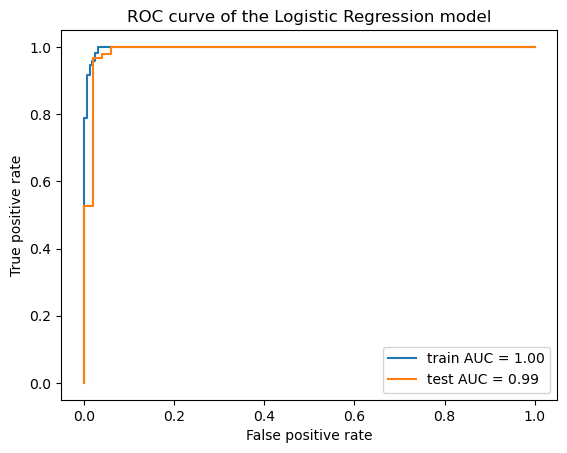

In [21]:
plot_roc(
    [y_true_train, y_true_test], [y_score_train, y_score_test],
    ["train", "test"]
)

# 交叉验证

$\quad$在模型**超参数优化**(hyperparameter optimization, HPO)的过程中, 为了不浪费训练数据, 往往采取**交叉验证**(cross validation, CV)的方法. 本次上机实习将演示**k-折**(k-fold)交叉验证: 将训练集$\mathcal{D}$拆分成若干个数据子集的不交并$\mathcal{D} = \mathcal{D}_1 \cap \mathcal{D}_2 \cap \dots \cap \mathcal{D}_k$, 作$k$轮循环. 在每轮循环中留出某一份作验证集, 其余部分作训练集, (独立地)训练一个模型. 将$k$个(初始配置相同、训练集不同的模型的平均性能作为交叉验证的结果.
```
D = [D1, ..., Dk]
for i = 1, ..., k:
    model = Model()
    train, valid = D / D[i], D[i]
    model.train(train)
    metric = model.eval(train, valid)
    metrics.append(metric)
report average metrics (or gap)
```

$\quad$对于一般的超参数优化, 标准流程是: (1) 设定超参数探索的空间(备选的若干组超参数配置); (2) 对每组超参数配置运行交叉验证, 考察平均性能; (3) 选择性能最优的模型, 在全体训练集$\mathcal{D}$上完成训练, 用于后续评估与应用. 本次上机实习与作业暂不涉及.

$\quad$如果认为“模型架构 + 超参数配置”确定了一个模型, 那么超参数优化的过程也可以认为是模型挑选的过程(事实上模型架构相关的参数也可以认为是超参数, 比如神经网络深度、特征个数等). 这也是`sklearn`将数据集分割、交叉验证相关的组件都封装在`model_selection`这一模块的原因. 具体流程示于[下图](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance):

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/77a37c22163c4ca5ab88fd1037dc3035/jToJCYcfqzpYDuNhqCCGcg.png).

$\quad$以下的代码示出如何使用k-折交叉验证的迭代器[`sklearn.model_selection.KFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn-model-selection-kfold)在数据集`X_train, y_true_train`上实现5折交叉验证. 这种基于迭代器的实现能让我们对数据集的预处理、结果预测等实现更加灵活和模块化的控制.

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/d0e069639aa2432e9fdfeb3eb3d0af1d/EBIubjxaWllqrqyS1a2SdA.png)

In [22]:
from sklearn.model_selection import KFold

n_splits = 5
kf = KFold(n_splits=n_splits)
accs = {"train": [], "valid": []}
for train, valid in kf.split(X_train_scaled):
    # note that the `kf.split` method generates the indices to split
    X_train_scaled_, X_valid_scaled_, y_true_train_, y_true_valid_ = X_train_scaled[train], X_train_scaled[valid], y_true_train[train], y_true_train[valid]
    clf = LogisticRegression().fit(X_train_scaled_, y_true_train_)
    y_pred_train_ = clf.predict(X_train_scaled_)
    y_pred_valid_ = clf.predict(X_valid_scaled_)
    accs["train"].append(accuracy_score(y_true_train_, y_pred_train_))
    accs["valid"].append(accuracy_score(y_true_valid_, y_pred_valid_))

accs

{'train': [0.9882352941176471,
  0.9824046920821115,
  0.9824046920821115,
  0.9882697947214076,
  0.9882697947214076],
 'valid': [0.9534883720930233,
  0.9882352941176471,
  1.0,
  0.9764705882352941,
  0.9411764705882353]}

In [23]:
sum(accs["train"]) / len(accs["train"]), sum(accs["valid"]) / len(accs["valid"])

(0.9859168535449371, 0.97187414500684)